# Pool-based Active Learning for Regression - Getting Started
This notebook gives on overview over some query strategies for active learning in
regression.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

from skactiveml.pool import GreedySamplingX, GreedySamplingTarget, QueryByCommittee, \
    KLDivergenceMaximization
from sklearn.ensemble import BaggingRegressor
from skactiveml.regressor import NICKernelRegressor, SklearnRegressor
from skactiveml.utils import call_func, is_labeled
from scipy.stats import norm, uniform

First, we generate a dataset. This notebook provides one of four datasets.

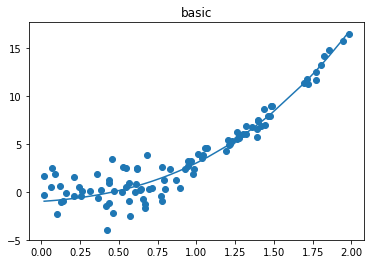

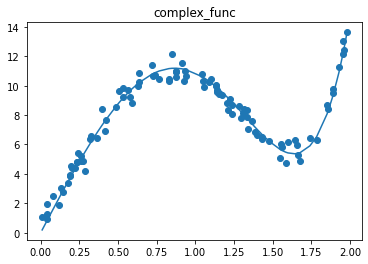

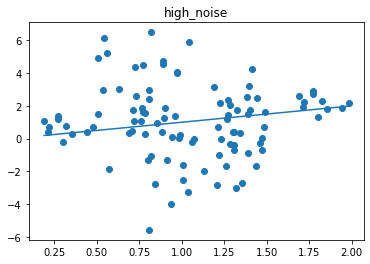

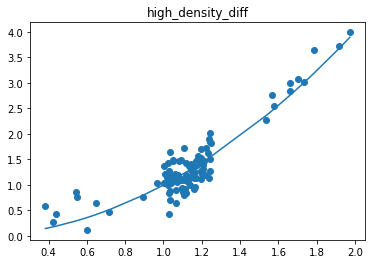

In [2]:
random_state = 0
n_iterations = 8

def uniform_rvs(*pos_args, **key_word_args):
    return uniform.rvs(*pos_args, **key_word_args, random_state=random_state)

def norm_rvs(*pos_args, **key_word_args):
    return norm.rvs(*pos_args, **key_word_args, random_state=random_state)

settings = {
    'basic': (
        lambda X_: (X_**3 + 2*X_**2 + X_ - 1).flatten(),
        np.sort(np.concatenate((uniform_rvs(0, 1, 60),uniform_rvs(1, 0.5, 30), uniform_rvs(1.5, 0.5, 10)))),
        np.concatenate((norm_rvs(0, 1.5, 60), norm_rvs(0, 0.5, 40)))
    ),
    'complex_func': (
        lambda X_: (6/7*X_**6 - 10*X_**3 + 20*X_).flatten(),
        np.sort(uniform_rvs(0, 2, 100)),
        norm_rvs(0, 0.5, 100)
    ),
    'high_noise': (
        lambda X_: X_.flatten(),
        np.sort(np.concatenate(tuple(uniform_rvs(s, 0.5, n) for s, n in [(0, 10), (0.5, 40), (1.0, 40), (1.5, 10)]))),
        np.concatenate(tuple(norm_rvs(0, std, n) for std, n in [(0.5, 10), (2.5, 80), (0.5, 10)]))
    ),
    'high_density_diff': (
        lambda X_: (X_**2).flatten(),
        np.sort(np.concatenate((uniform_rvs(0, 1, 10), uniform_rvs(1, 0.25, 80), uniform_rvs(1.25, 0.75, 10)))),
        norm_rvs(0, 0.25, 100)
    )
}

for variant in ['basic', 'complex_func', 'high_noise', 'high_density_diff']:
    true_function, X, noise = settings[variant] 
    X = X.reshape(-1, 1)
    y_true = true_function(X) + noise
    X_test = np.linspace(0, 2, num=200).reshape(-1, 1)

    plt.title(variant)
    plt.scatter(X, y_true)
    plt.plot(X, true_function(X))
    plt.show()

Now we want to look at how the different query strategies determine
which sample to query. We do so by looking at the utility assigned by
each query strategy for querying a samples. The assigned utility is displayed
by the lightgreen line matching the axis to the right. The unlabeled samples
are lightblue, the already labeled samples are orange, and the samples selected
to be queried next is red. The model prediction, build by the orange samples, are
displayed in black.

In this section a small evaluation of the query behavior of the above presented
query strategies is given based on the `basic` data set.

GreedySamplingX queries labels quiet uniformly over the feature space creating utility spikes
evenly between the labeled samples across the feature space.

GreedySamplingTarget has a strong tendency to query labels where the target values are steep if
the function is monotone, since there the target values differ the most from the prediction.

QueryByCommittee only queries, where some target data is available, slowly gaining diversity.
This happens because all the learners share the same prior and thus do not differ,
where no target data exist.

KLDivergenceMaximization seems to rely on the steepness of the target data
the density and the variance, which seems to create a quiet uniform querying
density.

basic


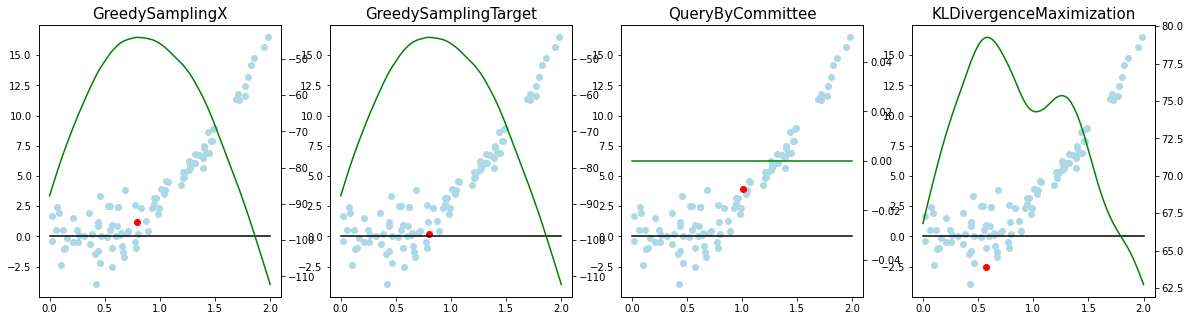

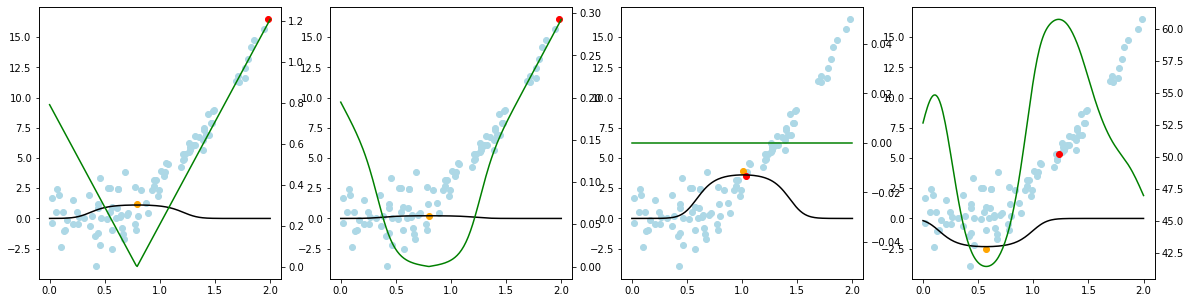

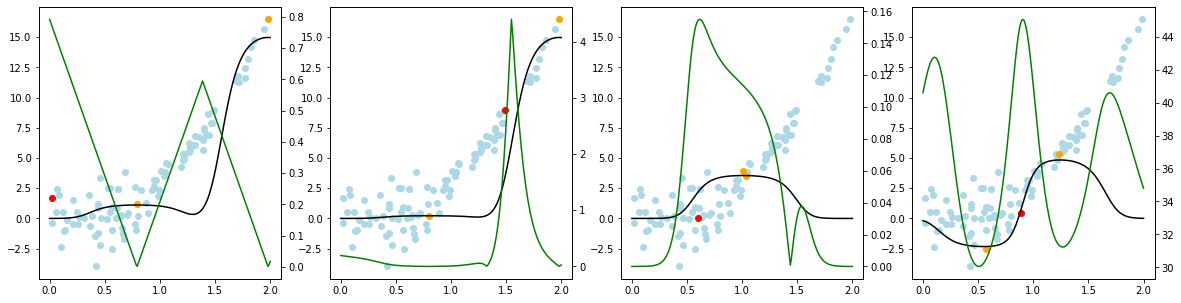

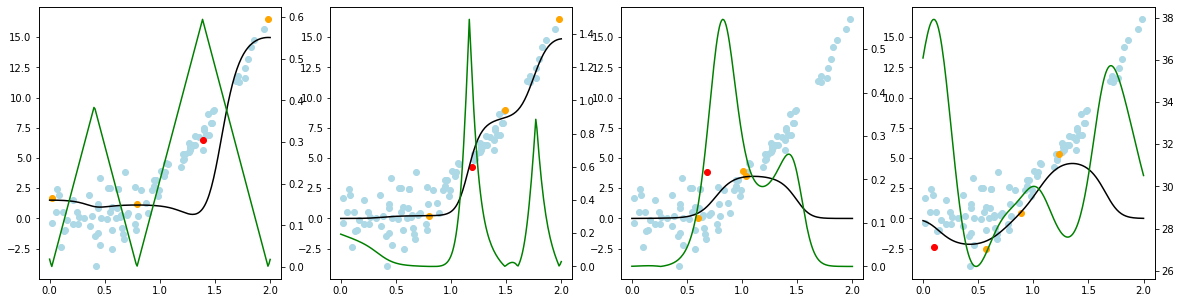

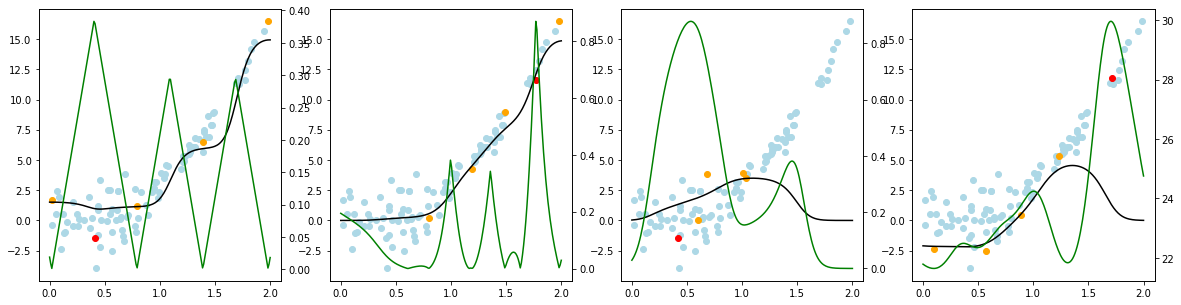

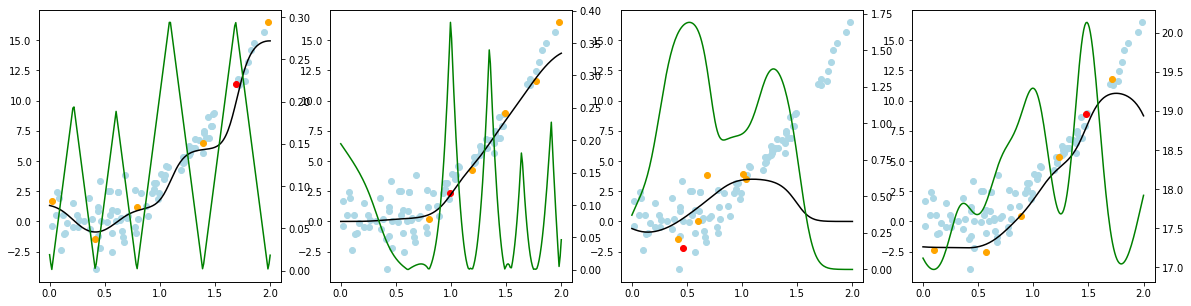

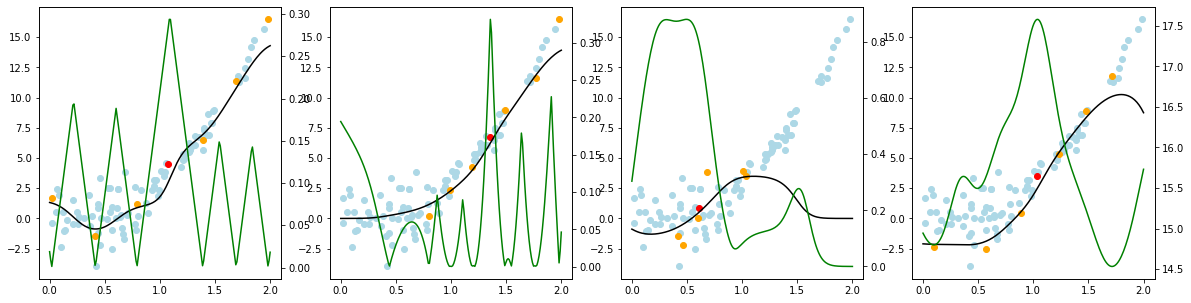

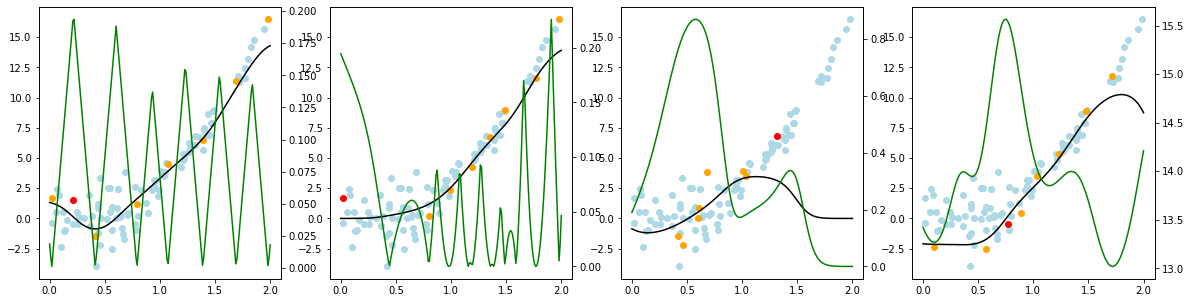

complex_func


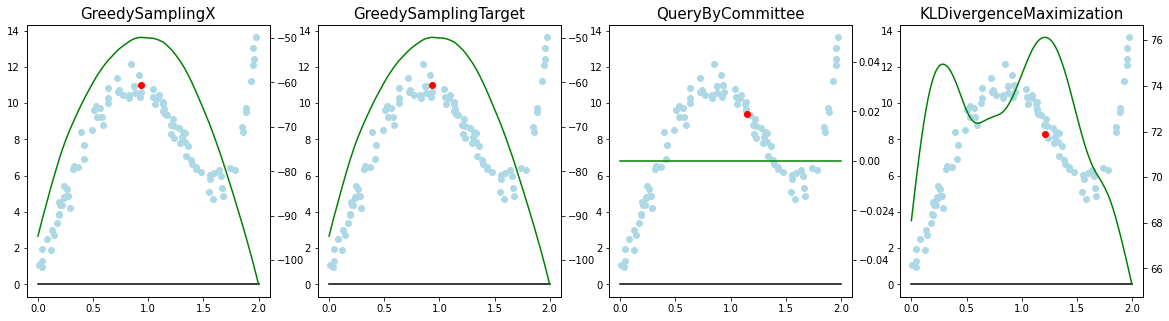

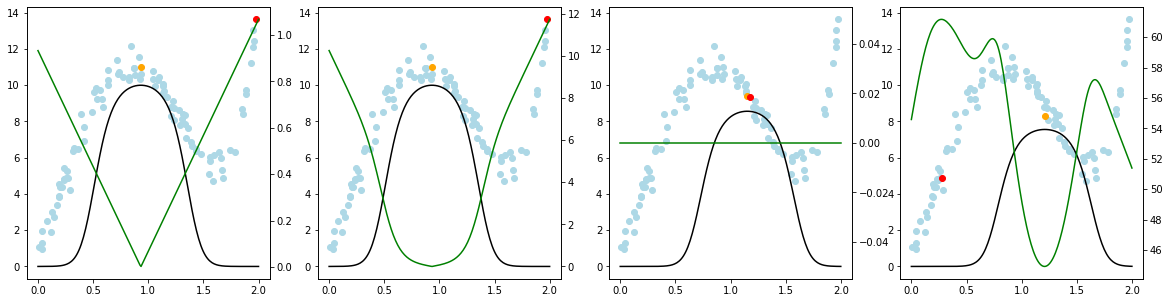

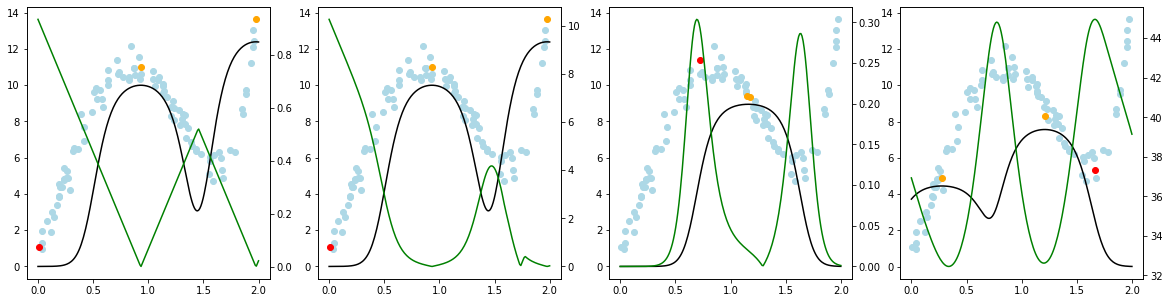

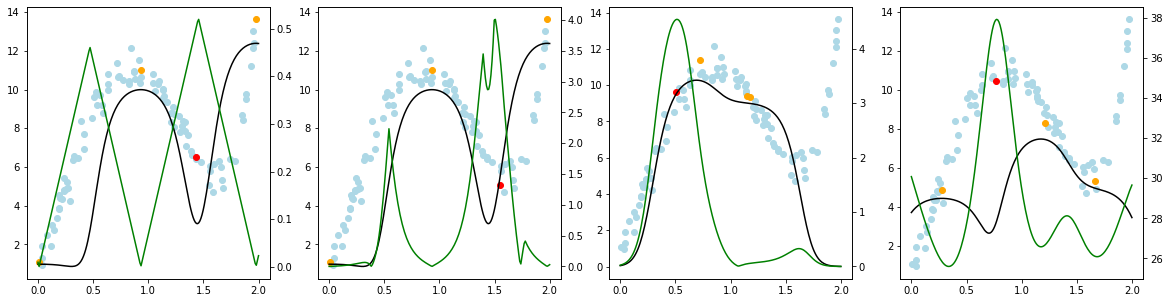

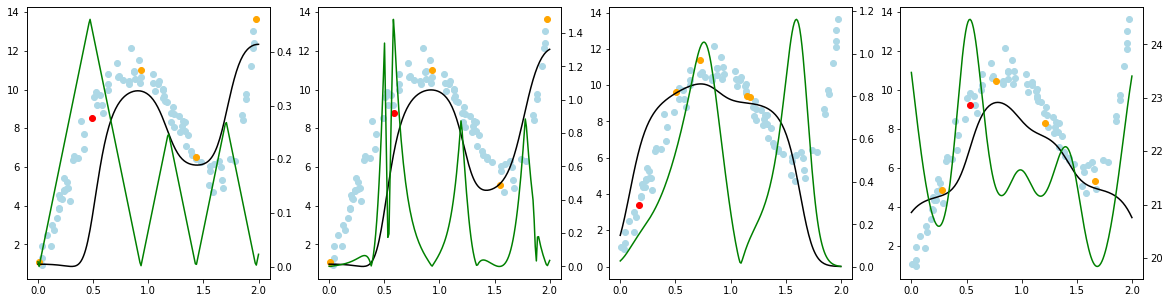

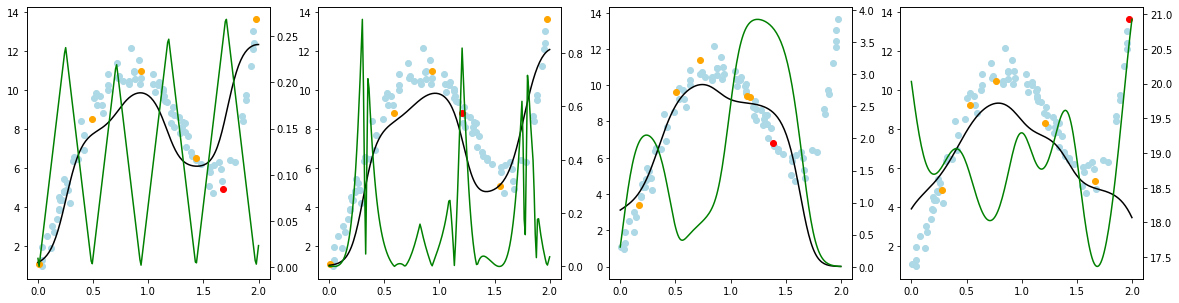

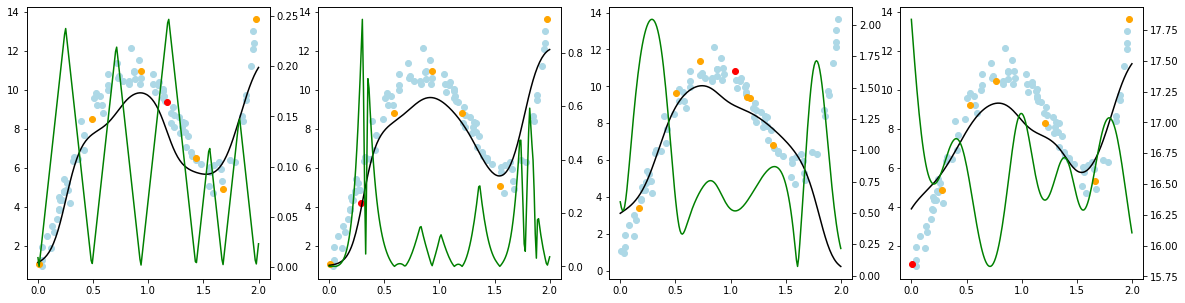

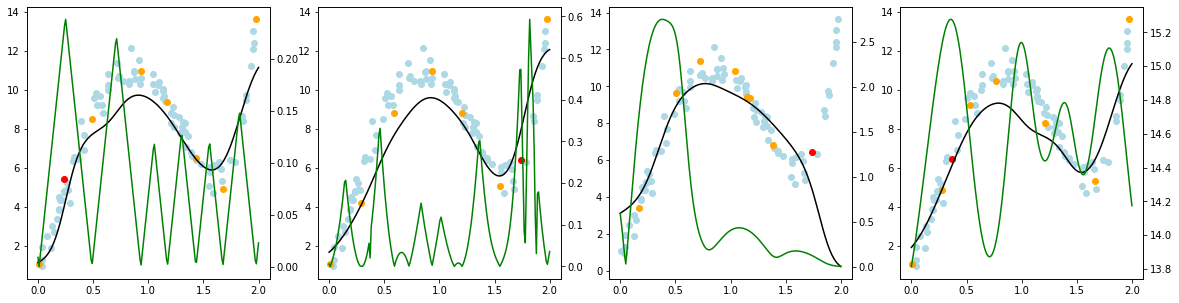

high_noise


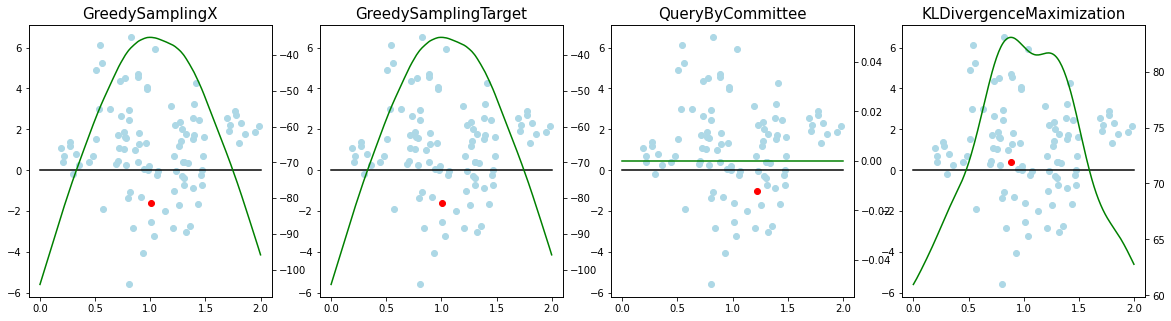

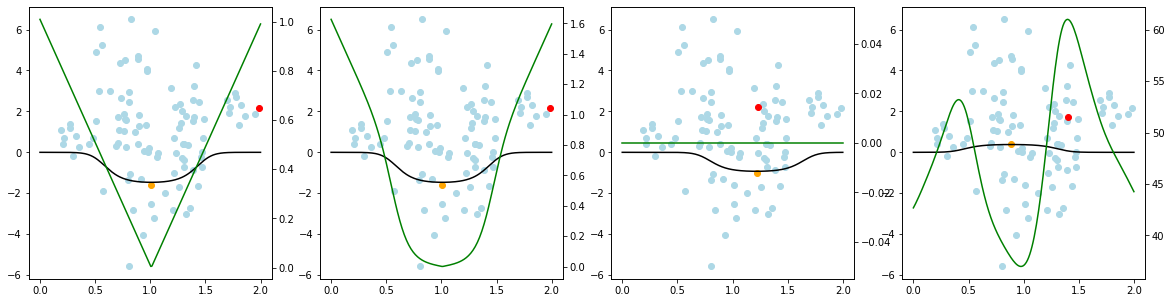

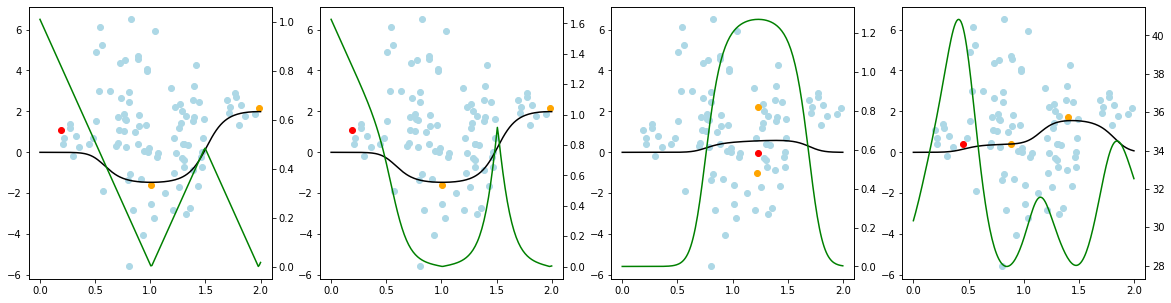

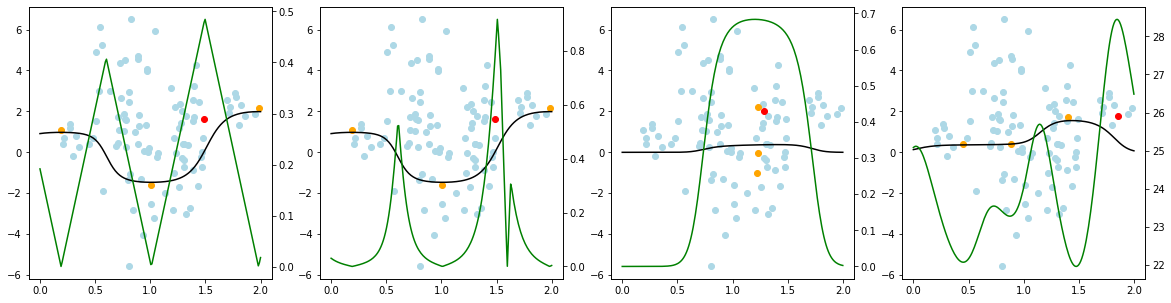

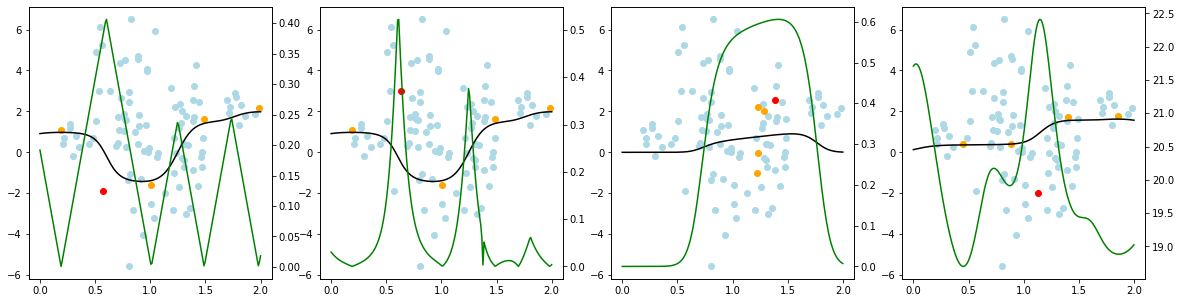

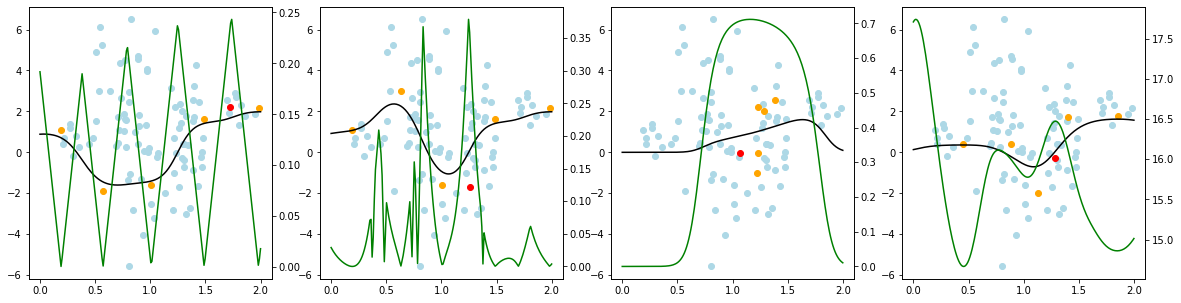

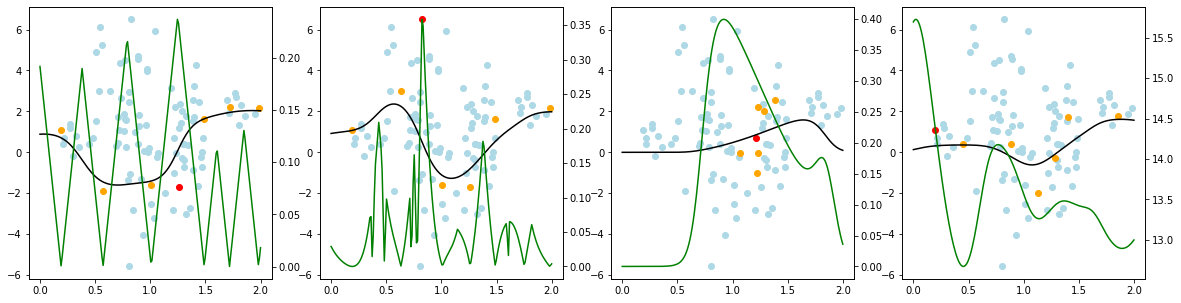

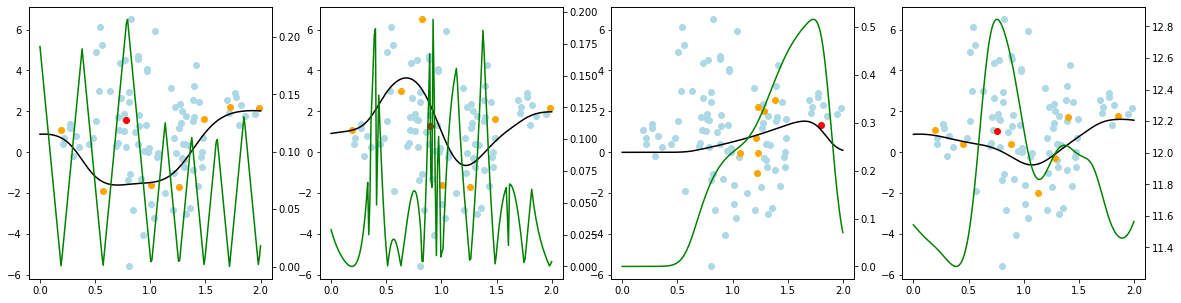

high_density_diff


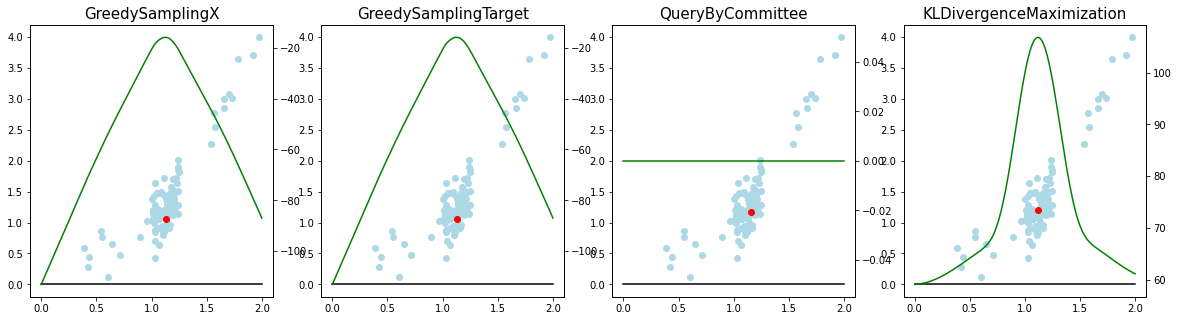

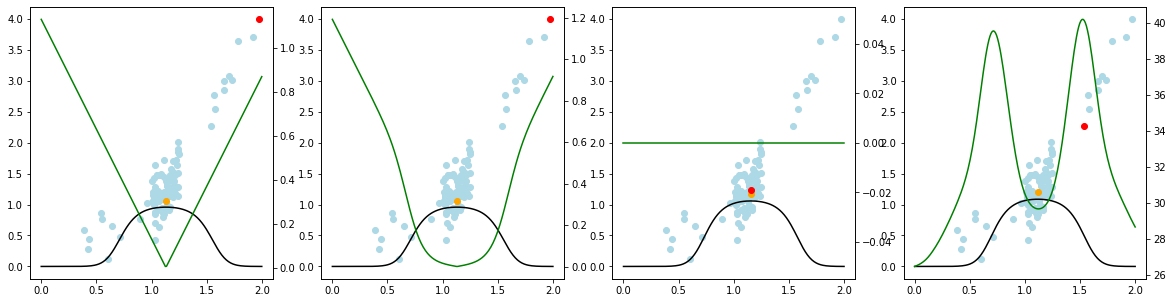

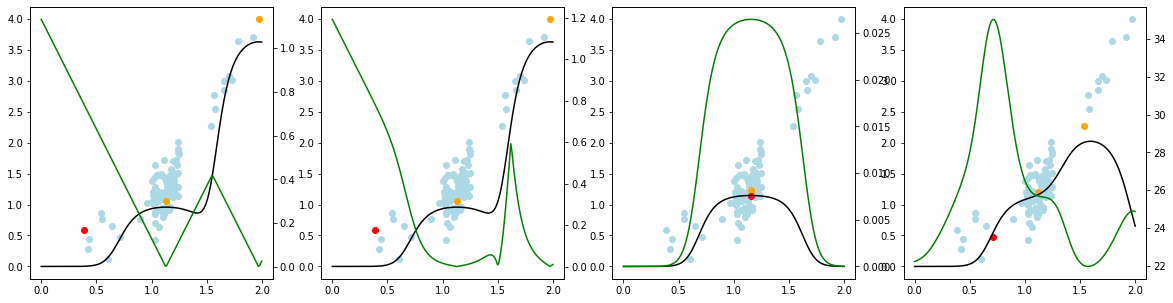

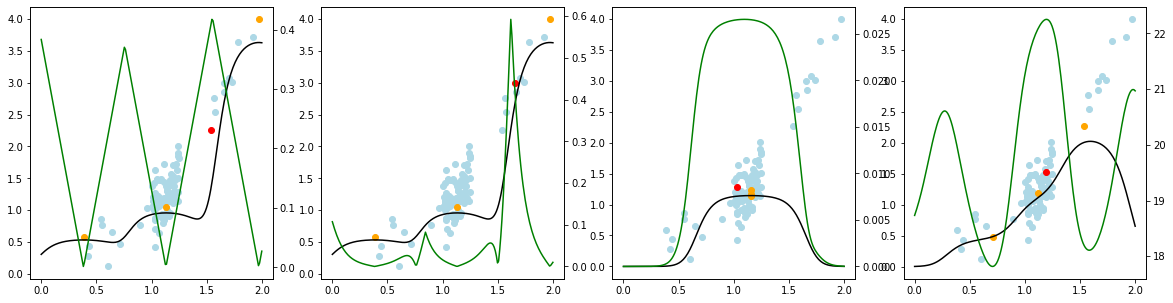

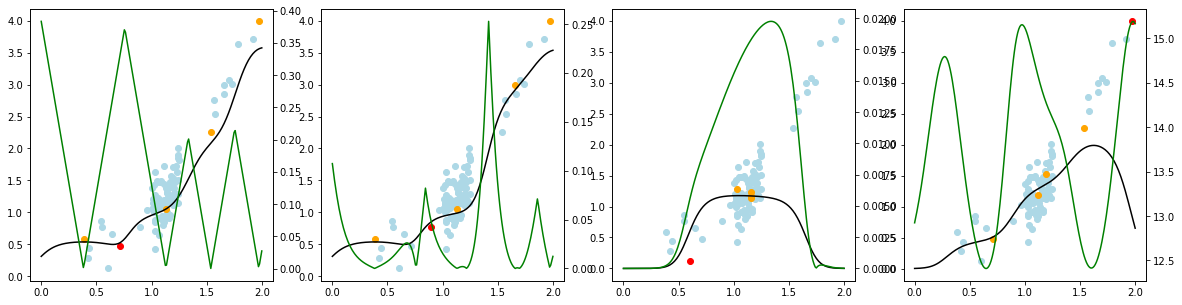

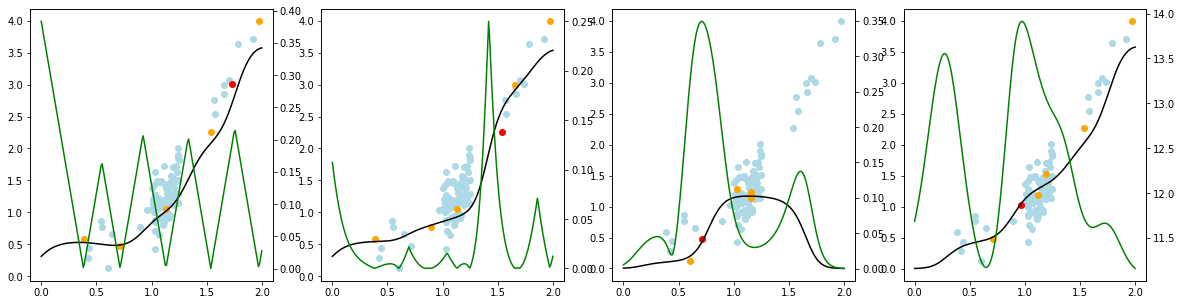

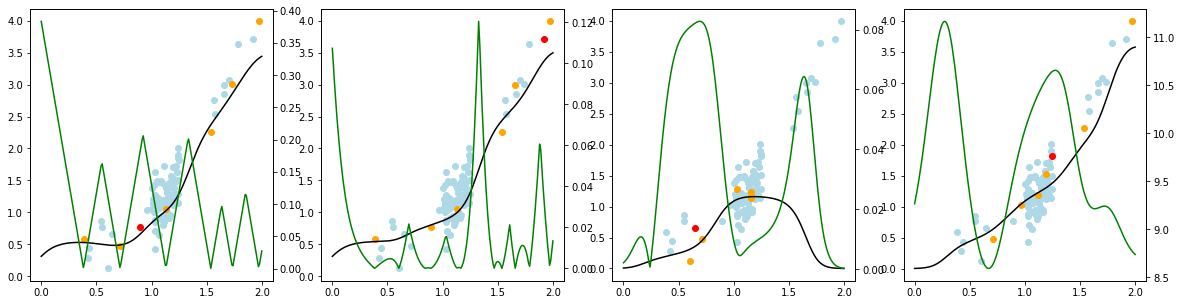

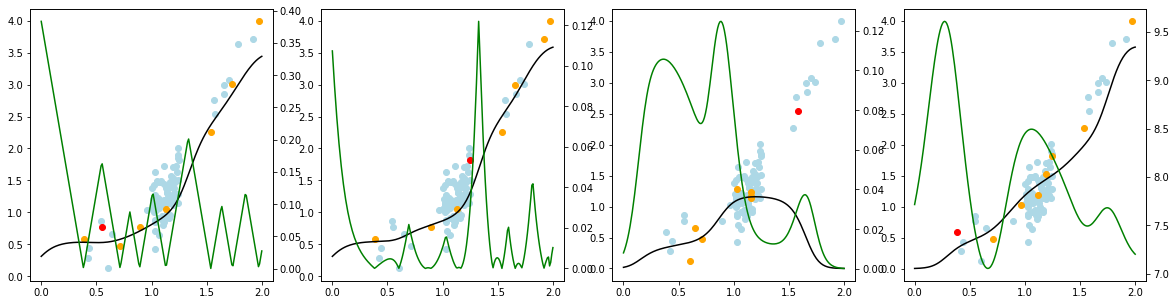

In [3]:
for variant in ['basic', 'complex_func', 'high_noise', 'high_density_diff']:
    print(variant)

    true_function, X, noise = settings[variant] # select another data set here
    X = X.reshape(-1, 1)
    y_true = true_function(X) + noise
    X_test = np.linspace(0, 2, num=200).reshape(-1, 1)

    qs_s = [
        GreedySamplingX(random_state=random_state),
        GreedySamplingTarget(random_state=random_state),
        QueryByCommittee(random_state=random_state),
        KLDivergenceMaximization(
            random_state=random_state,
            integration_dict_target_val={
                "method": "gauss_hermite",
                "n_integration_samples": 5,
            },
        ),
    ]

    y = np.full_like(y_true, np.nan)
    y_s = [y.copy() for _ in range(len(qs_s))]

    reg = NICKernelRegressor(metric_dict={'gamma': 15.0})

    for i in range(n_iterations):
        fig, axes = plt.subplots(1, len(qs_s), figsize=(20, 5))
        axes = [axes, ] if len(qs_s)==1 else axes

        for qs, ax, y in zip(qs_s, axes, y_s):
            reg.fit(X, y)
            indices, utils = call_func(qs.query,
                X=X,
                y=y,
                reg=reg,
                ensemble=SklearnRegressor(BaggingRegressor(reg, n_estimators=4)),
                fit_reg=True,
                return_utilities=True,
            )
            _, utilities_test = call_func(qs.query,
                X=X,
                y=y,
                reg=reg,
                ensemble=SklearnRegressor(BaggingRegressor(reg, n_estimators=4)),
                candidates=X_test,
                fit_reg=True,
                return_utilities=True,
            )
            old_is_lbld = is_labeled(y)
            y[indices] = y_true[indices]
            is_lbld = is_labeled(y)
            ax_t = ax.twinx()
            ax_t.plot(X_test, utilities_test.flatten(), c='green')

            ax.scatter(X[~is_lbld], y_true[~is_lbld], c='lightblue')
            ax.scatter(X[old_is_lbld], y[old_is_lbld], c='orange')
            ax.scatter(X[indices], y[indices], c='red')

            y_pred, y_std = reg.predict(X_test, return_std=True)
            ax.plot(X_test, y_pred, c='black')
            if i == 0:
                ax.set_title(qs.__class__.__name__, fontdict={'fontsize': 15})

        plt.show()